In [1]:
import tensorflow

In [2]:
import zipfile
zip = zipfile.ZipFile("/content/drive/MyDrive/Image_caption_generator/Flickr8k_text.zip")
zip.extractall()
zip.close()

In [3]:
zip = zipfile.ZipFile("/content/drive/MyDrive/Image_caption_generator/Flickr8k_Dataset.zip")
zip.extractall()
zip.close()

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# all necessary modules
import numpy as np
import pandas as pd
import nltk
from keras.layers import LSTM

In [6]:
# This function is reading all the data of text files and convert it into a string and returns it
def read_doc(filename):
  """FUNCTION:
        read_doc:
           Arguements: path of the file
           returns: all the data of file in string format  
  """
  with open(filename, "r") as f:
    file_details = f.read()
  return file_details

In [7]:
def all_img_captions(filename):
  """FUNCTION:
        all_img_captions:
            Arguements: path of file 
            returns: dictionary:
                       keys: image name
                       values: list of captions of that image       
  """
  details = read_doc(filename)   #reading the file and getting details of all the file

  details = details.split("\n")  # splitting all the lines and getting a list 
  
  descriptions = {}              #initializing a new dictionary
  
  for caption in details[:-1]:  #iterating throuth the list of all the lines of file
  
    img,caption_txt = caption.split("\t") # splitting the name of image and their captions 
  
    if img[:-2] not in descriptions:  #checking for the name of image in the dictionary
      descriptions[img[:-2]] = [caption_txt]  #making new key as name of image and assiging list of caption as value
    else:
      descriptions[img[:-2]].append(caption_txt) #appending the new caption in the list of the captions of same image
  
  return descriptions

In [8]:
nltk.download("stopwords")
from nltk.corpus import stopwords
from string import punctuation

def clean_caption_text(descriptions):
  """FUNCTION:
        Arguements: dictionary 
                       keys: image name
                       values: list of captions
        returns: dictionary:
                   keys: image name
                   values: list of cleaned captions
  """
  stops = stopwords.words("english") + list(punctuation) #getting stopwords and punctuation list
  
  for img,captions in descriptions.items(): #iterating through dictionary getting img name and its caption list
  
    for index,img_cap in enumerate(captions): # iterating through list of captions and getting a single caption with its index 
  
      img_cap = img_cap.replace("-","") # replacing "-" with empty string
   
      words = img_cap.lower().split()  #splitting all the words of string and getting a list of words
   
      words = [word for word in words if word not in stops] # removing stopwords and punctuation from list of words
   
      words = [word  for word in words if len(word)>1] # removing a single letter words lis 's
   
      words = [word  for word in words if word.isalpha()] # removing digits from he words and geeting only alphabates

      caption = " ".join(words)  # after cleaning combining list of words to a single string
     
      descriptions[img][index] = caption # changing the image caption with new cleaned caption into the caption list of the images description dictionary

  return descriptions # returning the dictionary with clean captions text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
def vocabulary(descriptions):
  """FUNCTION:
          vocabulary: 
               Arguements: dictionary of descriptions
               returns: set of all the unique words  
  """
  vocab = set()
  for img,captions in descriptions.items():
    for cap in captions:
      cap = cap.split()
      vocab.update(cap)

  return vocab


In [10]:
def save_descriptions(descriptions,filename):
  """FUNCTION:
         save_descriptions:
              Arguements: description dictionary and new filename in which you want to save
  """
  lines = []
  for img,captions in descriptions.items():
    for caption in captions:
      line = img + "\t" + caption   # image name tab captions of that image
      lines.append(line)
  total_data = "\n".join(lines)  # converting it into a single string 
  with open(filename,"w") as f:
    f.write(total_data)
  return 


In [11]:
filename = "/content/Flickr8k.token.txt"  # token file path 

image_descriptions = all_img_captions(filename) # calling the function for getting dictionary of descriptions

clean_image_descriptions =clean_caption_text(image_descriptions) # calling the function for getting dictionary of descriptions with cleaned captions text

vocabulary_words = vocabulary(clean_image_descriptions) #getting vocabulary means a set of all the unique words

save_descriptions(clean_image_descriptions,"desc.txt") #saving the clean descriptions in a new file

In [12]:
# from keras.applications.xception import Xception
# from PIL import Image
# import os
# from tqdm import tqdm_notebook as tqdm
# from pickle import dump,load
# tqdm().pandas()
# def extract_features(directory_name):
#   model = Xception(include_top = False,pooling = "avg")
#   features = {}
#   for img in tqdm(os.listdir(directory_name)):
#     filename = directory_name + "/" + img
#     image = Image.open(filename)
#     image = image.resize((299,299))
#     image = np.expand_dims(image,axis=0)
#     image = image/127.5
#     image = image-1.0

#     feature = model.predict(image)
#     features[img] = feature
#   return features


# features = extract_features("/content/Flicker8k_Dataset")
# dump(features,open("features.p","wb"))

In [13]:
def load_photos(filename):
  with open(filename,"r") as f:
    img_names = f.read()
  img_names = img_names.split("\n")[:-1]
  return img_names


In [14]:
def load_clean_descriptions(filename,photos):
  """FUNCTION:
        load_clean_descriptions:
                  Arguements: path of the clean descriptions file and list of name of images
                  returns: dictionary:
                              keys: images name
                              values: captions of images with <start> and <end> tag
  """
  descriptions = read_doc(filename) # loading the clean descriptions file (in our case desc.txt)

  descriptions = descriptions.split("\n") # splitting the lines of te file and getting lines into a list

  trained_descriptions = {}  #initializing a new list
  
  for lines in descriptions: # iterating through descriptions list

    words = lines.split()  # splitting the words of the lines and getting a list of individual words

    if len(words)<1:  # checking if the list is empty and skippig that iteration
      continue

    img_name,captions = words[0],words[1:] # list first element is an image name and rest all are words of a caption
    
    if img_name in photos: # checking for the image name in photos list which contains trained images name
    
      if img_name not in trained_descriptions: # checking for the image name in our new dictionary
    
        trained_descriptions[img_name] = [] # giving an empty list if the image is not present in our new dictionary

      """ here we use join because we have an list of words of a caption 
          Example : captions = ['child','pink','dress','climbing','set','stairs','entry','way']
      """
      captions = "<start>" + " ".join(captions) + "<end>" # adding the tags in our captions for LSTM model in future

      """ here we are appending caption into a list (key (image_name) : values (list of captions)) 
      Example : {'1000268201_693b08cb0e.jpg': ['<start>child pink dress climbing set stairs entry way<end>]'}
      """
      trained_descriptions[img_name].append(captions) # appending the caption into a list of a particular image

  return trained_descriptions


In [15]:
from pickle import load,dump
def load_features(filename,photos):
  """FUNCTION:
         load_features:
              Arguements: path of features file and list of images name
              returns: dictionary:
                        key : image name
                        value : features of that image

  """
  #loading all the features of images from features.p file
  all_features = load(open(filename,"rb"))
  # selecting features of only trained images list (photos)
  trained_features = {img:all_features[img] for img in photos}
  #returning new dictionary of img_name and features of only training set
  return trained_features

In [16]:
# loading images name in trained txt file 
photos = load_photos("/content/Flickr_8k.trainImages.txt")
# file path of our description file 
filename = "/content/desc.txt"
# getting training captions of images for our LSTM model
trained_descriptions = load_clean_descriptions(filename,photos)
# getting features of images of our training set
trained_features = load_features("/content/drive/MyDrive/Image_caption_generator/features.p",photos)

In [17]:
def dict_to_list(descriptions):
  # initializing an list
  all_desc = []
  for key in descriptions.keys(): #iterating through the keys of dictionary
    for d in descriptions[key]: # iterating through list of captions
      all_desc.append(d)  # appending each captions into te list
  return all_desc


In [18]:
from keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
  
  desc_list = dict_to_list(descriptions) # converting the dictionary into list of captions only
  
  tokenizer = Tokenizer() # making object of tokenizer class
  
  tokenizer.fit_on_texts(desc_list) # fitting that object on our list of captions
  
  return tokenizer #returning the object 

In [19]:
# calling the function for tokenizing each word in our dictionary
tokenizer = create_tokenizer(trained_descriptions)

dump(tokenizer,open("/content/drive/MyDrive/Image_caption_generator/tokenizer.p","wb"))

vocab_size = len(tokenizer.word_index) + 1

vocab_size

7459

In [20]:
# getting the maximum length of a caption in a raw description dictionary (function: all_img_captions output)
def Max_length(descriptions):
  
  desc_list = dict_to_list(descriptions)
  
  return max(len(d.split()) for d in desc_list)

In [21]:
# getting maixmum length of a caption
max_length = Max_length(image_descriptions)

In [22]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def create_sequences(descriptions_list,feature,tokenizer,max_length):
  """FUNCTION:
        create_sequences:
               Arguements: captions list of the image, list of features of that image, object of tokenizer, maximum length of a caption
               returns: list of features of an image for input in model, list of words in integers for inputs in model, list of words in categorical form the output word which comes after input word
  
  NOTE: For more understanding refer to the image input_for_models
  """


  # initializing list for image features as input(X1), captions words for that image(X2), output words comes after the input word() 
  X1 , X2, y = [],[],[]
  
  for desc in descriptions_list: # iterating over the captions list
  
    seq = tokenizer.texts_to_sequences([desc])[0] # using tokenizer to convert each word into a number of sequence
    # example: [Machine learning] -> [1,2] 

    for i in range(1,len(seq)): # iterating over length of sequences
      # making a list of input words(in integers) and output word comes just after input word 
      in_seq, out_seq = seq[:i], seq[i]
      """Example: i=2:
            seq = [Machine learning is easy] -> [1,2,3,4]
            in_seq = [1,2]
            out_seq = [3]
      """
      # pading sequence according to maxmimum length of a caption in our case it is 20
      in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
      #example: in_seq = [1] -> [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

      # doing one hot encoding by making dummy variables (in short handling categorical data according to size of vocablury)
      # because the size of vocabulary is our total number of classes or outputs
      out_seq = to_categorical([out_seq], num_classes = vocab_size )[0]
      
      #appending the features of the single image
      X1.append(feature)
      
      # appending the input words for our model (in integers) afet applying padding also because our model need fix size of inputs for all captions length
      X2.append(in_seq)
      
      # appending the next word which models need to predict means the word after the input word
      y.append(out_seq)
  # converting all the list into numpy arrays for fast calculations
  return np.array(X1),np.array(X2),np.array(y)

In [23]:
def data_generator(descriptions,features,tokenizer,max_length):
  """FUNCTION:
        data_generator:
              Arguements: dictionary of descriptions, features dictionary(features.p), object of tokenizer, maximum length of a caption.
              returns: image features list, word list for inputs in model, list of words for output or output values for models 
  """
  while 1:  # running infinte loop for getting batched according to demand
  
    for key, descriptions_list in descriptions.items():  # iterating through descriptions dictionary
  
      feature = features[key][0] # getting the feature value of that image
  
      # calling another function for producing format of inputs and outputs for our models
      input_image,input_sequence,output_word = create_sequences(descriptions_list,feature,tokenizer,max_length)

      # yielding of sending output in batches on demand where the function is called 
      yield [[input_image,input_sequence],output_word]

In [24]:
# loading the features of all the descriptions given by Xception model
features = load(open("/content/drive/MyDrive/Image_caption_generator/features.p","rb"))
# calling the generator function and getting the value in batches
[a,b],c = next(data_generator(trained_descriptions,features,tokenizer,max_length))
# getting the value of 34 batches where a= features set, b = captions, c= output (y)
a.shape,b.shape,c.shape

((34, 2048), (34, 20), (34, 7459))

In [25]:
from tensorflow.keras.utils import plot_model
from keras.layers.merge import add
from keras.models import Model,load_model
from keras.layers import Input,Dense,LSTM,Embedding,Dropout

def define_model(vocab_size,max_length):
  """FUNCTION:
        define_model:
             Arguements: integer number size of our vocabulary, maximum length of a caption
             returns: model or a object
        NOTE: See model.png image for more information.     
  """

  input_1 = Input(shape = (2048,)) # defining input for our dense layer (features of a image)
  
  features_layer_1 = Dropout(0.5)(input_1) # adding dropout layer which removes 0.5 values from our models which are not useful

  features_layer_2 = Dense(256,activation = "relu")(features_layer_1) # adding a dense layer with 256 units or neurons with rectifier activation function

  input_2 = Input(shape=(max_length,)) #defining input layer for LSTM layer

  seq_layer_1 = Embedding(vocab_size,256,mask_zero = True)(input_2) # converts the a single word categorical data to 256 vectors values for easy computations
  # search for working of embedding layer you will get to know how it works

  #adding dropout layer for removing .5 percent for unuseful values
  seq_layer_2 = Dropout(0.5)(seq_layer_1)
 
  #adding an LSTM layer(RNN) for taking words as input and predict the next word
  seq_layer_3 = LSTM(256)(seq_layer_2)
  
  # merging both the layers together
  decoder_1 = add([features_layer_2,seq_layer_3])

  # adding another dense layer for handling both layers input and giving output to output layer
  decoder_2 = Dense(256,activation = "relu")(decoder_1)

  # defining output layer with units equal to vocab size because we have number of classes equals to vocabulary size
  outputs = Dense(vocab_size,activation = "softmax")(decoder_2)
  
  # defining our model with inputs and outputs structur, this model class will make the final structure of our model
  model = Model(inputs = [input_1,input_2],outputs = outputs)
  
  #compiling the model with loss function and optimizer
  model.compile(optimizer = "adam",loss = "categorical_crossentropy")
  
  # gives tabular data of details of all the layers and their units and input values etc.
  print(model.summary())
  
  # saving the model structure into an image
  plot_model(model, to_file = "model.png",show_shapes = True)
  
  #returning the whole model
  return model


In [26]:
import os
from tqdm.notebook import tqdm
print("dataset: ", len(photos))
print("descriptions train: ",len(trained_descriptions))
print("Photos train: ", len(trained_features))
print("vocabulary size: ",vocab_size)
print("Descriptions Length: ",max_length)

model = define_model(vocab_size,max_length) #calling the function for getting the model

epochs = 10 # running our model 10 times on our given dataset(here training set)
steps = len(trained_descriptions) # steps are the number of images on which our model is running(or training)
os.mkdir("models_1") # making a directory for saving the model state after each epoch

# for i in tqdm(range(epochs)): #  iterating for 10 times on our training set

#   # calling this function to give input and out values in batches
#   generator = data_generator(trained_descriptions,trained_features,tokenizer,max_length) 
  
#   # fitting the model on our training set inputs (genrator is the format of inputs our model needs)
#   #here number of epochs is one because we are training our model on a batch for a single time
#   model.fit_generator(generator,epochs = 1 , steps_per_epoch = steps,verbose =1) 

#   # saving the model state after each epoch into the directory for future use
#   model.save("models_1/model_"+ str(i) + ".h5")

# # this procedure will take time according to your CPU processing 

dataset:  6000
descriptions train:  6000
Photos train:  6000
vocabulary size:  7459
Descriptions Length:  20
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 20, 256)      1909504     ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_1[0][0]']  

In [47]:
from PIL import Image
from keras.applications.xception import Xception
import argparse
import numpy as np
import matplotlib.pyplot as plt
import os,sys


def extract_feature(filename,model):
  """FUNCTION:
         extract_features:
                 Arguements: path of the image, xception model
                 returns: features of that image
  """

  image = Image.open(filename) #opening the image and saving it state

  image = image.resize((299,299)) # resizing the image into 299*299

  image = np.array(image) # converting the image values into numpy array

  # if image has four channels then we reduce it to 3
  if image.shape[2]==4:
    image = image[..., :3] # taking only 3 channels of the image(Example:- rgb = red,green,blue)

  image = np.expand_dims(image,axis = 0) # expanding or adding one more dimension

  image = image/127.5  # reducing the image pixels values

  image = image - 1.0 # reducing the image pixels values

  feature = model.predict(image) # predicting the features of the image using xception model of keras

  return feature #returning the features of the image

def word_for_id(integer,tokenizer):
  """FUNCTION:
       word_for_id:
             Arguements: integer index value of the word, tokenizer object which have all the words of our vocabulary
             returns: the word according to its index
  """
  for word,index in tokenizer.word_index.items(): # iterating thorugh dicionary of words as keys and index value as vavlues 
    
    if  index == integer: #searching for that index which is predicted by our model in vocabulary 
      return word #returning the word which index matches with our predicted index

  return None # returning None if that word is not present in our vocabulary

def generate_desc(model,tokenizer,photo,max_length):

  in_text = "start"  # inidicator taht the description is start
  for i in range(max_length): #iterating upto maximum length of the caption

    sequence = tokenizer.texts_to_sequences([in_text])[0] #converting the text values into integers of sequences

    sequence = pad_sequences([sequence],maxlen = max_length) # padding the sequence to maxmin length of a caption

    pred = model.predict([photo,sequence],verbose = 0) # predicting the word of the description for that image

    pred =np.argmax(pred) #finding the index of the maximum value into the array

    word = word_for_id(pred,tokenizer) #calling the function for getting the word according to this index value in our vocabulary

    if word is None: # if word is not present in vocbulary
      break
    in_text += " " + word # adding that word in the in_text
    if word == "end": # it means we have reached the end of description
      break
  return in_text # returning the final description of that image


def test_descriptions(test_set):
  """FUNCTION:
        test_descriptions:
              Arguements: list of images name 
              returns: list of predicted descriptions
  """
  pred_desc = []  #initializing the list

  #loading the last trained model after completing each epoch
  model = load_model("/content/drive/MyDrive/Image_caption_generator/model_1/model_9.h5")

  # getting the xception model of keras library for getting feature of the given image
  xception_model = Xception(include_top = False,pooling = "avg")
  
  for image_name in test_set:
    path = "/content/Flicker8k_Dataset/" + image_name # getting the path of the image

    # checking for the existence of the image
    try:
      if not os.path.isfile(path):
        sys.exit()
    except:
      print("Image Doesn't exist in test set")
      continue

    #calling function for extracting the feature of given image
    photo = extract_feature(path,xception_model)

    # getting the caption of the given image whcih describes the image (or a text descriptions of a image)
    description = generate_desc(model,tokenizer,photo,max_length)

    # appending the description of the image
    pred_desc.append(description)

  return pred_desc  #returning the list of predicted descriptions


In [ ]:
with open("/content/Flickr_8k.testImages.txt","r") as f:

  test_set = f.read() # getting the string of all the images name in test set

test_set = test_set.split("\n")[:-1] # splitting the images 

pred_description = test_descriptions(test_set)  # getting the predicted descriptions of all the test set images

pred_description # checking the descriptions by printing

In [56]:
# for getting bleu score
from nltk.translate.bleu_score import sentence_bleu,corpus_bleu

actual,ref = [],[]  #initializing the lists

for key,desc_list in image_descriptions.items():  # iterating over all the descriptions of all the images

  if key in test_set: # checking that the image name is present in the descriptions 

    for d in desc_list: #iterating over captions of all the images

      ref.append(d.split()) # splitting the captions and getting the list of words for that caption

    actual.append(ref) # appending all the captions list words into a single list

predicted = [i.split() for i in pred_description] # spliiting the predicted captions into list of words

print(len(actual))
print(len(predicted))

print("1-gram %f" %corpus_bleu(actual,predicted,weights = (1,0,0,0)))
print("2-gram %f" %corpus_bleu(actual,predicted,weights = (0.5,0.5,0,0)))
print("3-gram %f" %corpus_bleu(actual,predicted,weights = (0.33,0.33,0.33,0)))
print("4-gram %f" %corpus_bleu(actual,predicted,weights = (0.25,0.25,0.25,0.25)))

1-gram 0.975415
2-gram 0.764637
3-gram 0.591163
4-gram 0.412177


start dog running water end


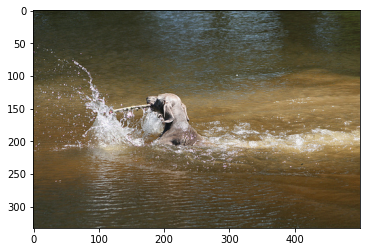

In [57]:
#visulaizing the image and its predicted description of a single image
img = Image.open("/content/Flicker8k_Dataset/" + test_set[557])
print(pred_description[557])
plt.imshow(img)

1000